In [1]:
# UNCOMMENT BELOW TO UPDATE THE DATA FILE ..\\data\\jake_files\\data_clean.csv
# import subprocess
# subprocess.run(['python','cleaning.py'])

import pandas as pd
import statsmodels.api as sm
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import timedelta

DATA_PATH = "..\\data\\jake_files\\"

In [2]:
df = pd.read_csv(f'{DATA_PATH}data_clean.csv').set_index('chargeid')
df_drugs = df[(df['offtype'] == 'drugs') & (df['sentyear'] >= 2011)].copy()

In [3]:
# USER DEFINED VARIABLES
# Sale/Intent to Sell/No Intent to Sell
df_drugs['sale'] = np.where(df_drugs['statute_long'].str.contains('Sale'), 1, 0)

df_drugs['offense_x_history'] = df_drugs['Offense'].str.replace(" ","") +'_history'+ df_drugs['history'].astype(int).astype(str)
df_drugs['offense_x_history_x_sale'] = df_drugs['Offense'].str.replace(" ","") +'_history'+ df_drugs['history'].astype(int).astype(str) +'_sale'+ df_drugs['sale'].astype(str)

df_drugs['presumptive_commitment'] = np.where(df_drugs['presumpt'] == 'commit', df_drugs['time'], 0)
df_drugs['pronounced_commitment'] = np.where(df_drugs['prison'] == 'yes', df_drugs['aggsentc'], 0)
df_drugs['presumptive_disposition'] = np.where(df_drugs['presumpt'] == 'commit', 1, 0)
df_drugs['pronounced_disposition'] = np.where(df_drugs['prison'] == 'yes', 1, 0)

df_drugs['post'] = np.where(pd.to_datetime(df_drugs['doff']) >= pd.to_datetime('2016-08-01'), 1, 0)

df_drugs['age_tercile'] = pd.cut(df['ageoff'], bins=[0, 30, 50, 100], labels=["Under 30", "30-50", "Over 50"], right=False)

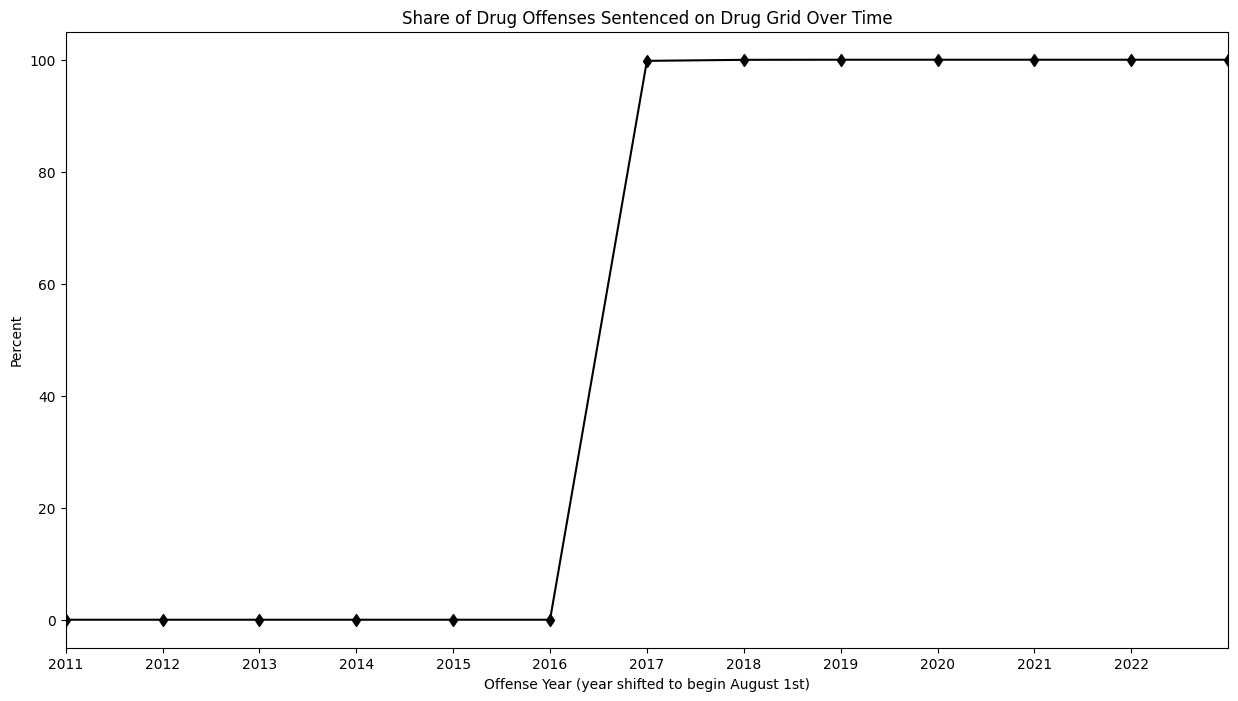

In [4]:
# FIGURE 1a: Share of Drug Grid Usage over time
drug_grid_usage_df = df_drugs[['doff','sentyear','severity']].copy()
drug_grid_usage_df['doff_year'] = (pd.to_datetime(drug_grid_usage_df['doff'], format='%Y-%m-%d') + timedelta(31 + 30 + 31 + 30 + 31)).dt.year
drug_grid_usage_df['drug_grid'] = np.where(df_drugs['severity'].str.contains('d'), 1, 0)
plot_df = drug_grid_usage_df.groupby('doff_year')['drug_grid'].mean().reset_index().set_index('doff_year') * 100

fig, ax = plt.subplots(figsize=(15, 8));
ax.set_title('Share of Drug Offenses Sentenced on Drug Grid Over Time');
ax.plot(plot_df, color='black', marker='d');

ax.set_ylabel('Percent');
ax.set_xlabel('Offense Year (year shifted to begin August 1st)');
ax.set_xlim(2011,2023)
ax.set_xticks(np.arange(2011,2023,1));

fig.savefig('..\\figures\\share_of_drug_offenses_on_drug_grid.png', bbox_inches='tight')

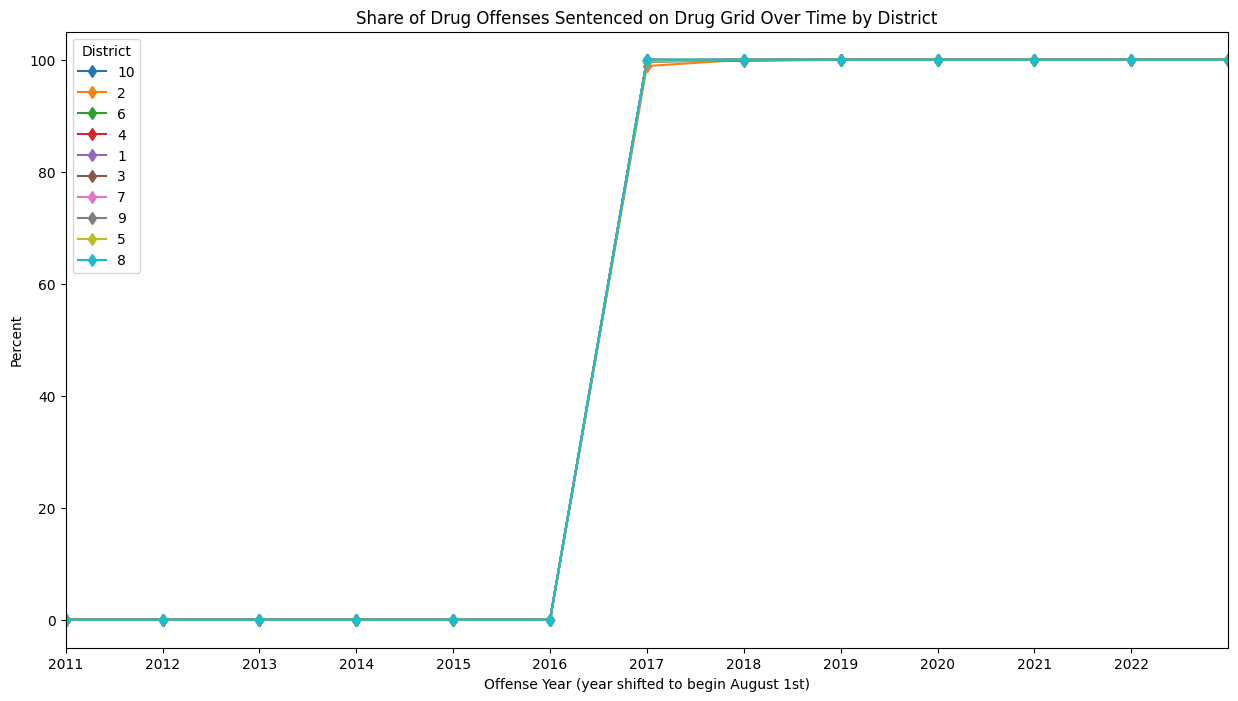

In [5]:
# FIGURE 1b: Share of Drug Grid Usage over time by district
drug_grid_usage_df = df_drugs[['doff','sentyear','district','severity']].copy()
drug_grid_usage_df['doff_year'] = (pd.to_datetime(drug_grid_usage_df['doff'], format='%Y-%m-%d') + timedelta(31 + 30 + 31 + 30 + 31)).dt.year
drug_grid_usage_df['drug_grid'] = np.where(df_drugs['severity'].str.contains('d'), 1, 0)
plot_df = drug_grid_usage_df.groupby(['doff_year','district'])['drug_grid'].mean().reset_index()
plot_df['drug_grid'] = plot_df['drug_grid'] * 100
plot_df['district'] = plot_df['district'].astype(int) 

# Defining colors for the districts
districts = plot_df['district'].unique()
colors = plt.get_cmap('tab10', len(districts))

fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('Share of Drug Offenses Sentenced on Drug Grid Over Time by District');

for idx, district in enumerate(districts):
    line_data = plot_df[plot_df['district'] == district]
    ax.plot(line_data['doff_year'], line_data['drug_grid'], marker='d', label=district, color=colors(idx))

ax.set_ylabel('Percent');
ax.set_xlabel('Offense Year (year shifted to begin August 1st)');
ax.set_xlim(2011,2023)
ax.set_xticks(np.arange(2011,2023,1));
ax.legend(title='District');

fig.savefig('..\\figures\\share_of_drug_offenses_on_drug_grid_by_district.png', bbox_inches='tight')

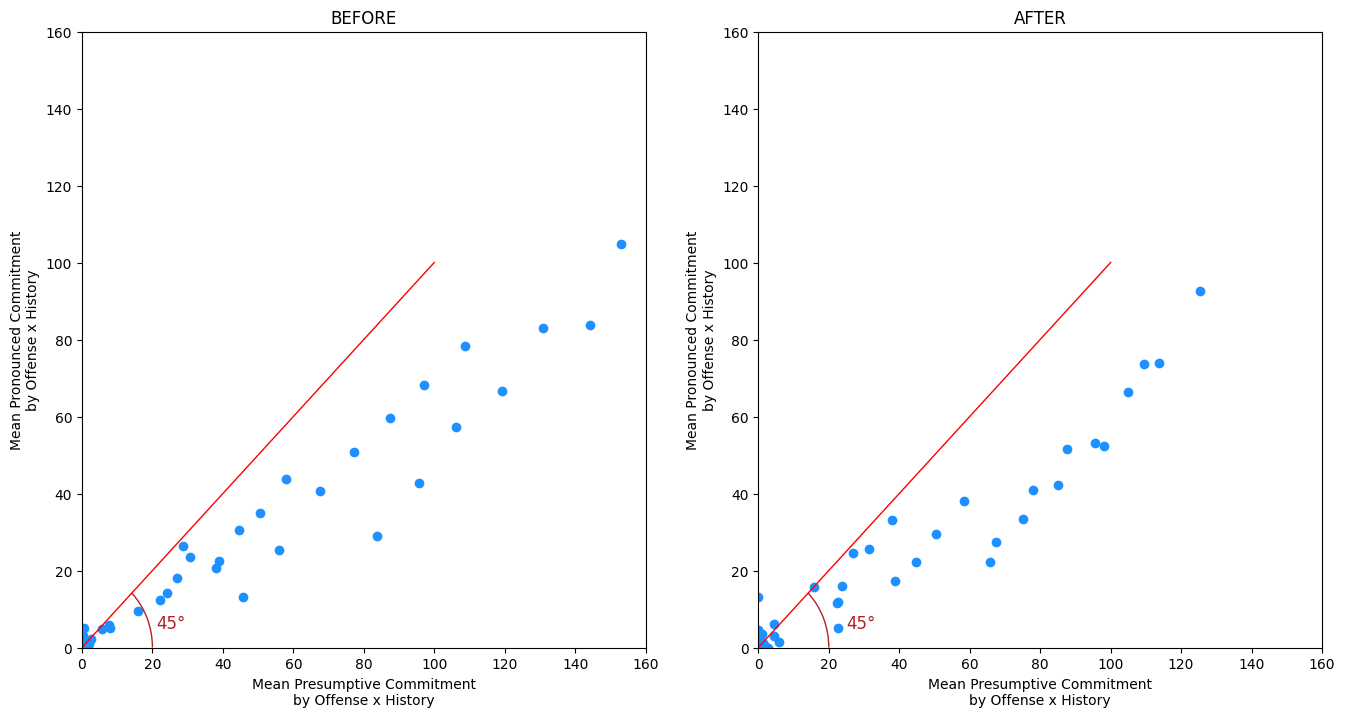

In [4]:
# FIGURE 2: Pre/Post similarities between presumptive & pronounced commitment
df_PRE = (df_drugs[df_drugs['post'] == 0]
                                    .groupby(['offense_x_history'])[['presumptive_commitment','pronounced_commitment']]
                                    .agg(['mean','std','count'])
                                    .reset_index()
                                    .set_index('offense_x_history')
                                )

df_POST = (df_drugs[df_drugs['post'] == 1]
                                    .groupby(['offense_x_history'])[['presumptive_commitment','pronounced_commitment']]
                                    .agg(['mean','std','count'])
                                    .reset_index()
                                    .set_index('offense_x_history')
                                )

diff_df = df_POST.join(df_PRE, lsuffix='_POST', rsuffix='_PRE')
diff_df.index = diff_df.index.str.replace('consub','Controlled Substance Degree ').str.replace('_history',' & Criminal History ')

binscatter_df = diff_df[[('presumptive_commitment_PRE',  'mean'),('pronounced_commitment_PRE',  'mean'),
                         ('presumptive_commitment_POST',  'mean'),('pronounced_commitment_POST',  'mean')]]



from matplotlib.patches import Arc

fig, (ax, ax2) = plt.subplots(1,2, figsize=(16,8))

ax.scatter(binscatter_df[('presumptive_commitment_PRE',  'mean')], binscatter_df[('pronounced_commitment_PRE',  'mean')], color='dodgerblue')
ax.set_xlim(0,160)
ax.set_ylim(0,160)
ax.set_xlabel('Mean Presumptive Commitment\nby Offense x History')
ax.set_ylabel('Mean Pronounced Commitment\nby Offense x History')
ax.set_title('BEFORE')

line_x = np.linspace(0, 100, 100)
line_y = line_x
ax.plot(line_x, line_y, color='red', linewidth=1)

arc = Arc((0, 0), 40, 40, angle=0, theta1=0, theta2=45, color='firebrick')
ax.add_patch(arc)
ax.text(21, 5, "45\u00B0", fontsize=12, color='firebrick')

ax2.scatter(binscatter_df[('presumptive_commitment_POST',  'mean')], binscatter_df[('pronounced_commitment_POST',  'mean')], color='dodgerblue')
ax2.set_xlim(0,160)
ax2.set_ylim(0,160)
ax2.set_xlabel('Mean Presumptive Commitment\nby Offense x History')
ax2.set_ylabel('Mean Pronounced Commitment\nby Offense x History')
ax2.set_title('AFTER')

ax2.plot(line_x, line_y, color='red', linewidth=1)

arc2 = Arc((0, 0), 40, 40, angle=0, theta1=0, theta2=45, color='firebrick')
ax2.add_patch(arc2)
ax2.text(25, 5, "45\u00B0", fontsize=12, color='firebrick')
fig.savefig('..\\figures\\presumptive_pronounced_binscatter.png', bbox_inches='tight');

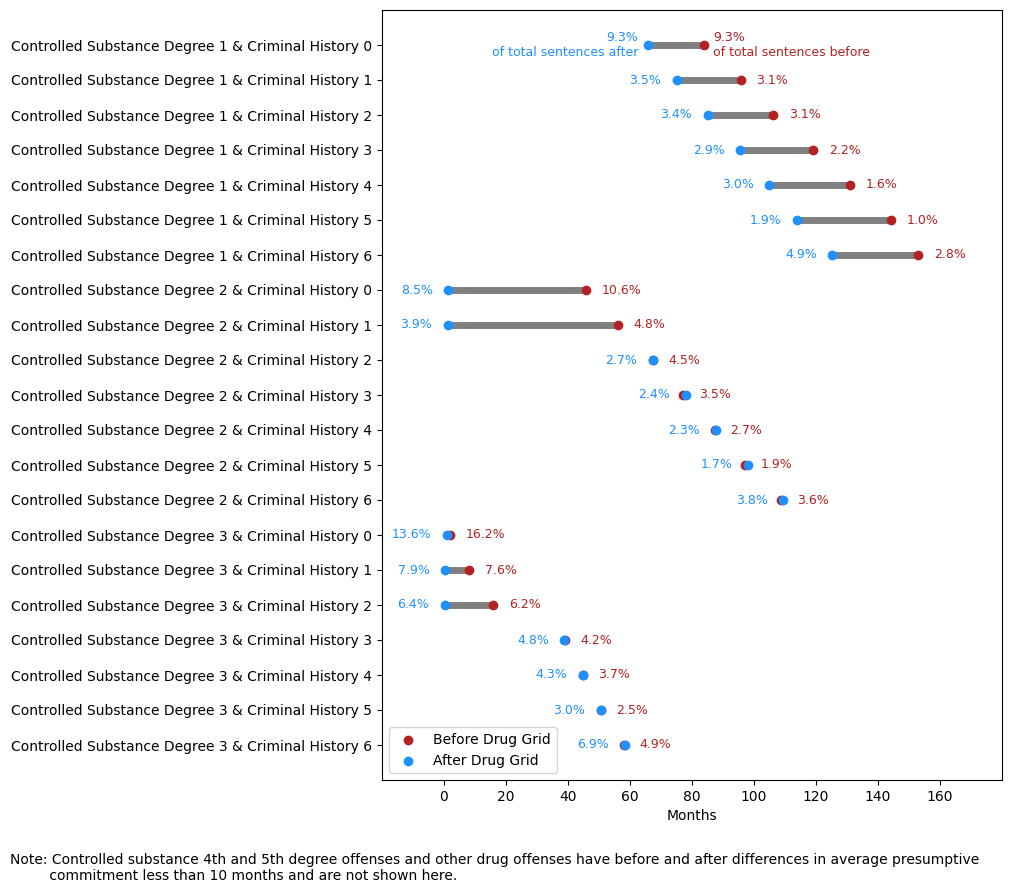

In [5]:
# FIGURE 3a: Changes in presumptive commitment
df_PRE = (df_drugs[df_drugs['post'] == 0]
                                    .groupby(['offense_x_history'])['presumptive_commitment']
                                    .agg(['mean','median','std','count'])
                                    .reset_index()
                                    .set_index('offense_x_history')
                                )

df_POST = (df_drugs[df_drugs['post'] == 1]
                                    .groupby(['offense_x_history'])['presumptive_commitment']
                                    .agg(['mean','std','count'])
                                    .reset_index()
                                    .set_index('offense_x_history')
                                )

diff_df = df_POST.join(df_PRE, lsuffix='_POST', rsuffix='_PRE').assign(mean_diff = lambda x: x['mean_POST'] - x['mean_PRE'])
diff_df.index = diff_df.index.str.replace('consub','Controlled Substance Degree ').str.replace('_history',' & Criminal History ')
diff_df = diff_df[['mean_POST','mean_PRE','mean_diff','count_POST','count_PRE']]
diff_df = diff_df.iloc[0:21].copy()

# Percents of offense x histories within just 1st, 2nd, 3rd degree offenses
diff_df['total_POST'] = diff_df['count_POST'].sum()
diff_df['total_PRE'] = diff_df['count_PRE'].sum()
diff_df['percent_POST'] = diff_df['count_POST'] / diff_df['total_POST'] * 100
diff_df['percent_PRE'] = diff_df['count_PRE'] / diff_df['total_PRE'] * 100


# FIGURE: Pre- and Post- changes in presumptive commitment
fig, ax = plt.subplots(figsize=(8,10))

for idx, off_hist in enumerate(reversed(diff_df.index)):
    y = off_hist
    a = diff_df.loc[off_hist, 'mean_PRE']
    b = diff_df.loc[off_hist, 'mean_POST']
    
    percent_pre = diff_df.loc[off_hist, 'percent_PRE']
    percent_post = diff_df.loc[off_hist, 'percent_POST']
    
    ax.scatter(a, y, color='firebrick', label='Before Drug Grid' if idx == 0 else None, zorder=2)
    ax.scatter(b, y, color='dodgerblue', label='After Drug Grid' if idx == 0 else None, zorder=2)
    ax.plot([a, b], [y, y], color='gray', zorder=1, linewidth=5)
    
    ax.text(a+5 if idx != len(diff_df.index) - 1 else a+3, y,
            f'{percent_pre:.1f}%' if idx != len(diff_df.index) - 1 else f'{percent_pre:.1f}%\nof total sentences before',
            color='firebrick', ha='left', va='center', fontsize=9)
    ax.text(b-5 if idx != len(diff_df.index) - 1 else b-3, y,
            f'{percent_post:.1f}%' if idx != len(diff_df.index) - 1 else f'{percent_pre:.1f}%\nof total sentences after',
            color='dodgerblue', ha='right', va='center', fontsize=9)

ax.set_xlabel('Months')
ax.set_xlim(-20,180)
ax.set_xticks(np.arange(0,180,20))
ax.legend()
fig.text(-0.34, 0.01, 'Note: Controlled substance 4th and 5th degree offenses and other drug offenses have before and after differences in average presumptive\n         commitment less than 10 months and are not shown here.', ha='left', fontsize=10);

# fig.savefig('..\\figures\\before_after_presumptive_commitment.png', bbox_inches='tight');
fig.savefig('..\\figures\\before_after_presumptive_commitment_with_percents.png', bbox_inches='tight');

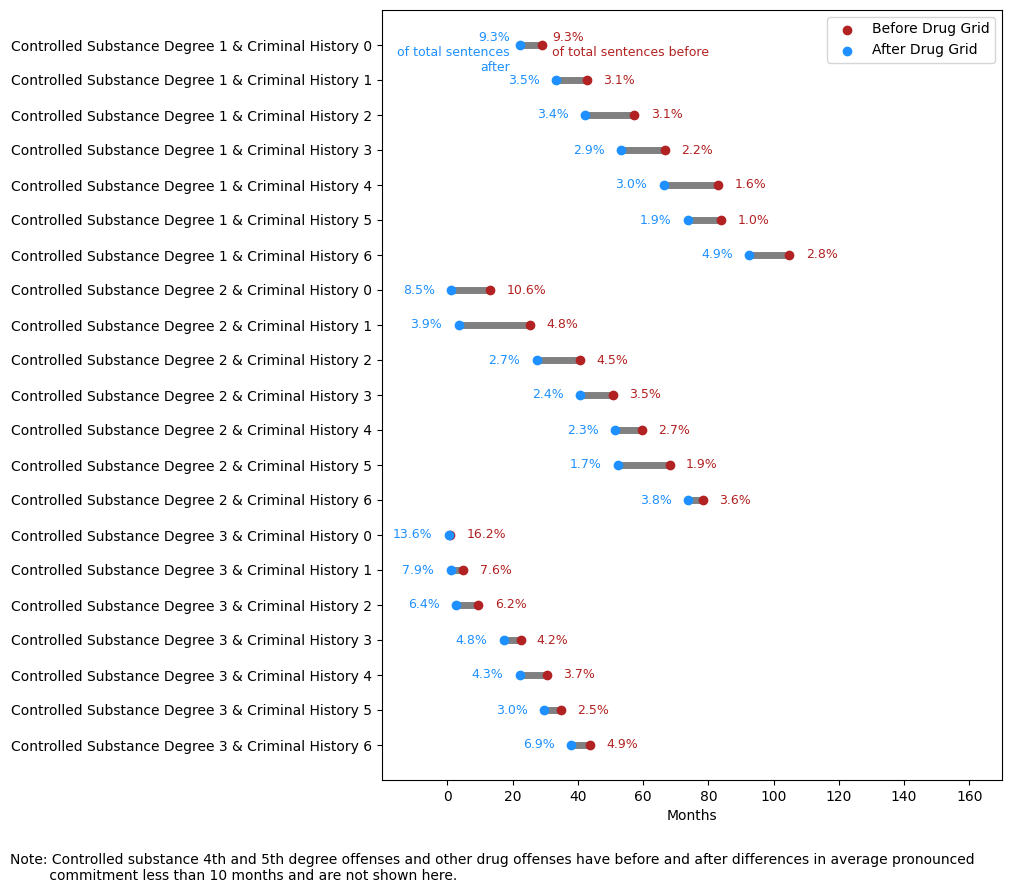

In [13]:
# FIGURE 3b: Changes in pronounced commitment
df_PRE = (df_drugs[df_drugs['post'] == 0]
                                    .groupby(['offense_x_history'])['pronounced_commitment']
                                    .agg(['mean','median','std','count'])
                                    .reset_index()
                                    .set_index('offense_x_history')
                                )

df_POST = (df_drugs[df_drugs['post'] == 1] 
                                    .groupby(['offense_x_history'])['pronounced_commitment']
                                    .agg(['mean','std','count'])
                                    .reset_index()
                                    .set_index('offense_x_history')
                                )

diff_df = df_POST.join(df_PRE, lsuffix='_POST', rsuffix='_PRE').assign(mean_diff = lambda x: x['mean_POST'] - x['mean_PRE'])
diff_df.index = diff_df.index.str.replace('consub','Controlled Substance Degree ').str.replace('_history',' & Criminal History ')
diff_df = diff_df[['mean_POST','mean_PRE','mean_diff','count_POST','count_PRE']]
diff_df = diff_df.iloc[0:21].copy()

# Percents of offense x histories within just 1st, 2nd, 3rd degree offenses
diff_df['total_POST'] = diff_df['count_POST'].sum()
diff_df['total_PRE'] = diff_df['count_PRE'].sum()
diff_df['percent_POST'] = diff_df['count_POST'] / diff_df['total_POST'] * 100
diff_df['percent_PRE'] = diff_df['count_PRE'] / diff_df['total_PRE'] * 100


# FIGURE: Pre- and Post- changes in pronounced commitment
fig, ax = plt.subplots(figsize=(8,10))

for idx, off_hist in enumerate(reversed(diff_df.index)):
    y = off_hist
    a = diff_df.loc[off_hist, 'mean_PRE']
    b = diff_df.loc[off_hist, 'mean_POST']
    
    percent_pre = diff_df.loc[off_hist, 'percent_PRE']
    percent_post = diff_df.loc[off_hist, 'percent_POST']
    
    ax.scatter(a, y, color='firebrick', label='Before Drug Grid' if idx == 0 else None, zorder=2)
    ax.scatter(b, y, color='dodgerblue', label='After Drug Grid' if idx == 0 else None, zorder=2)
    ax.plot([a, b], [y, y], color='gray', zorder=1, linewidth=5)
    
    ax.text(a+5 if idx != len(diff_df.index) - 1 else a+3, y,
            f'{percent_pre:.1f}%' if idx != len(diff_df.index) - 1 else f'{percent_pre:.1f}%\nof total sentences before',
            color='firebrick', ha='left', va='center', fontsize=9)
    ax.text(b-5 if idx != len(diff_df.index) - 1 else b-3, y,
            f'{percent_post:.1f}%' if idx != len(diff_df.index) - 1 else f'\n{percent_pre:.1f}%\nof total sentences\nafter',
            color='dodgerblue', ha='right', va='center', fontsize=9)

ax.set_xlabel('Months')
ax.set_xlim(-20,170)
ax.set_xticks(np.arange(0,170,20))
ax.legend()
fig.text(-0.34, 0.01, 'Note: Controlled substance 4th and 5th degree offenses and other drug offenses have before and after differences in average pronounced\n         commitment less than 10 months and are not shown here.', ha='left', fontsize=10);

# fig.savefig('..\\figures\\before_after_pronounced_commitment.png', bbox_inches='tight');
# fig.savefig('..\\figures\\before_after_pronounced_commitment_with_percents.png', bbox_inches='tight');
fig.savefig('..\\figures\\before_after_pronounced_commitment_with_percents_no20162017.png', bbox_inches='tight');

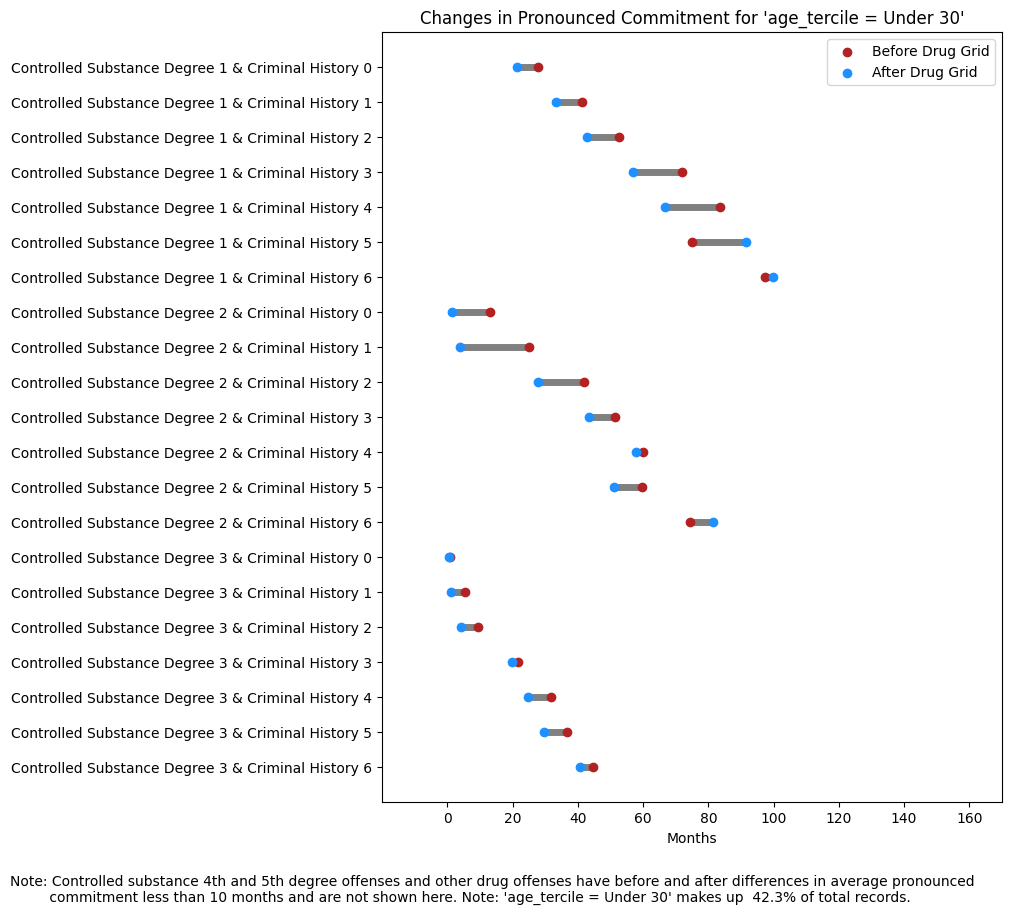

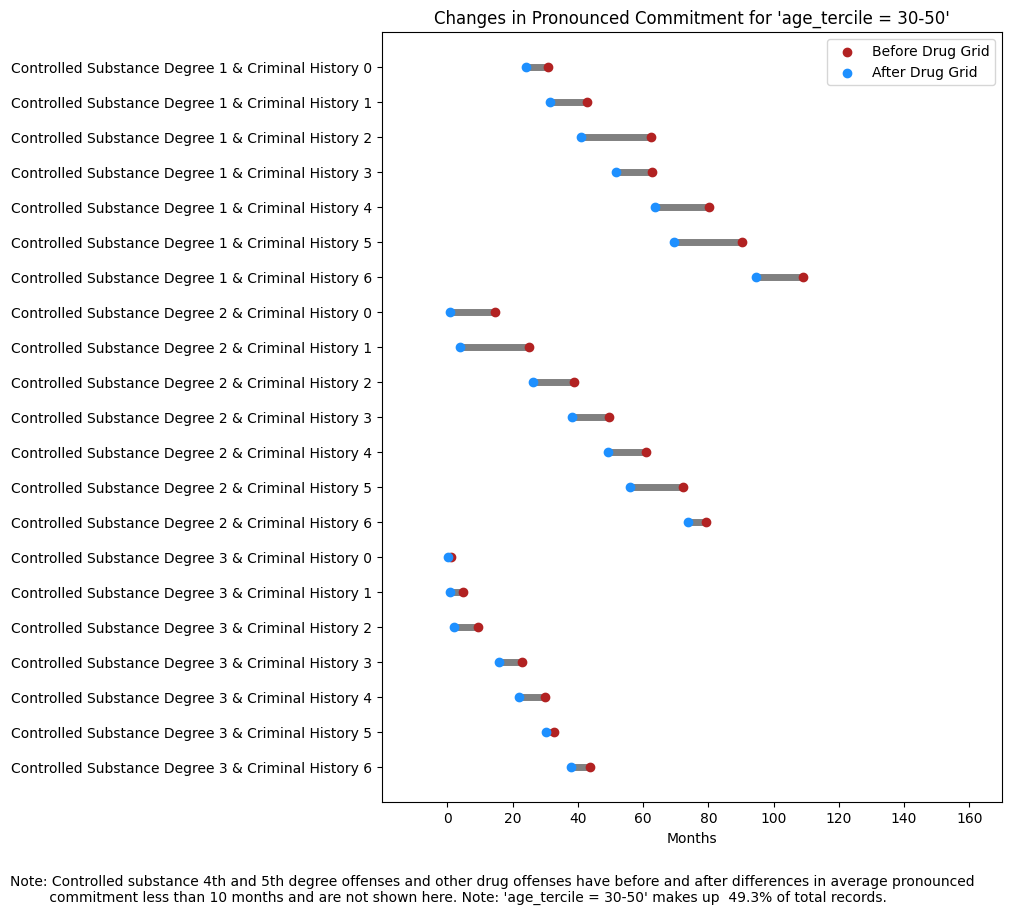

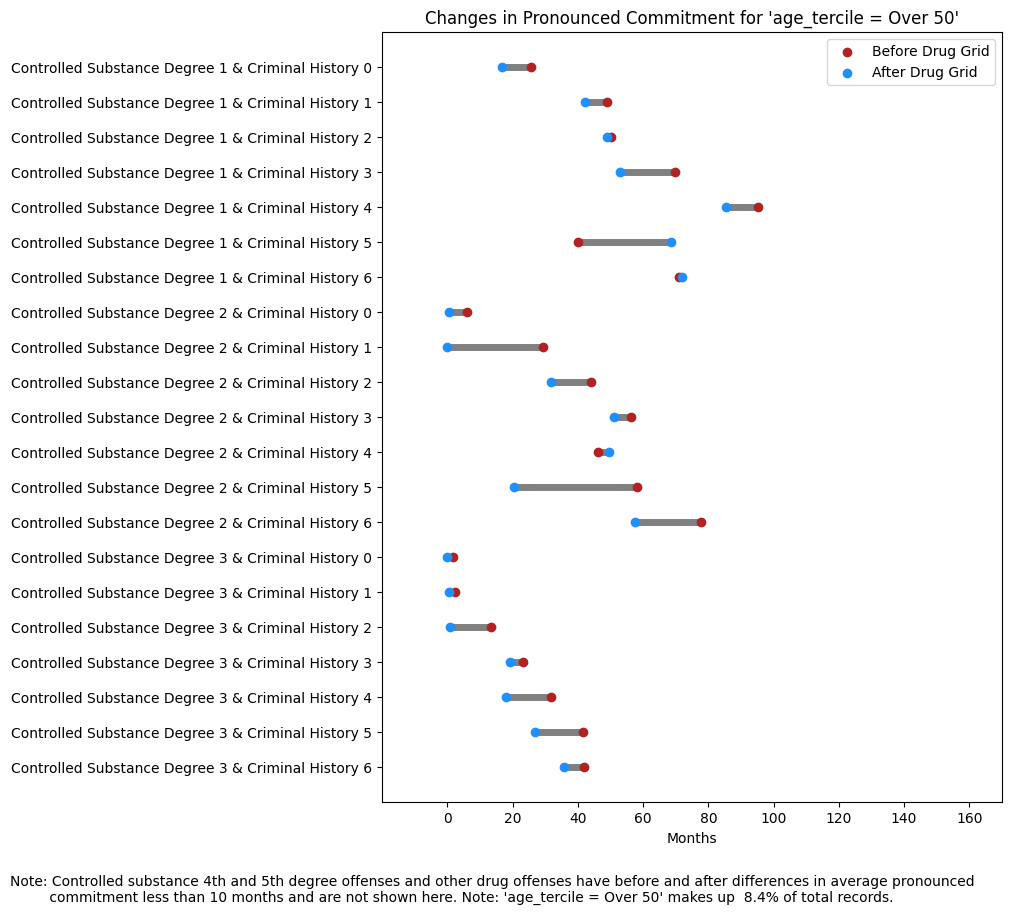

In [4]:
# FIGURE 3b_subgroups: Changes in pronounced commitment by factor
for age_idx in ["Under 30", "30-50", "Over 50"]: # np.arange(1,11), ['male','female'], ['white','black','am ind','hispanic','asian'], ...
    heterogeneity_factor = 'age_tercile' # 'district', 'sex', 'race' ...
    heterogeneity_level = age_idx
    percent_of_total_records = df_drugs[df_drugs[heterogeneity_factor] == heterogeneity_level].shape[0] / df_drugs.shape[0]

    df_PRE = (df_drugs[(df_drugs['post'] == 0) & #]
                    (df_drugs[heterogeneity_factor] == heterogeneity_level)]
                                        .groupby(['offense_x_history'])['pronounced_commitment']
                                        .agg(['mean','median','std','count'])
                                        .reset_index()
                                        .set_index('offense_x_history')
                                    )

    df_POST = (df_drugs[(df_drugs['post'] == 1) & #]
                        (df_drugs[heterogeneity_factor] == heterogeneity_level)] 
                                        .groupby(['offense_x_history'])['pronounced_commitment']
                                        .agg(['mean','std','count'])
                                        .reset_index()
                                        .set_index('offense_x_history')
                                    )

    diff_df = df_POST.join(df_PRE, lsuffix='_POST', rsuffix='_PRE').assign(mean_diff = lambda x: x['mean_POST'] - x['mean_PRE'])
    diff_df.index = diff_df.index.str.replace('consub','Controlled Substance Degree ').str.replace('_history',' & Criminal History ')
    diff_df = diff_df[['mean_POST','mean_PRE','mean_diff','count_POST','count_PRE']]
    diff_df = diff_df.iloc[0:21].copy()

    # Percents of offense x histories within just 1st, 2nd, 3rd degree offenses
    diff_df['total_POST'] = diff_df['count_POST'].sum()
    diff_df['total_PRE'] = diff_df['count_PRE'].sum()
    diff_df['percent_POST'] = diff_df['count_POST'] / diff_df['total_POST'] * 100
    diff_df['percent_PRE'] = diff_df['count_PRE'] / diff_df['total_PRE'] * 100


    # FIGURE: Pre- and Post- changes in pronounced commitment
    fig, ax = plt.subplots(figsize=(8,10))

    for idx, off_hist in enumerate(reversed(diff_df.index)):
        y = off_hist
        a = diff_df.loc[off_hist, 'mean_PRE']
        b = diff_df.loc[off_hist, 'mean_POST']
        
        percent_pre = diff_df.loc[off_hist, 'percent_PRE']
        percent_post = diff_df.loc[off_hist, 'percent_POST']
        
        ax.scatter(a, y, color='firebrick', label='Before Drug Grid' if idx == 0 else None, zorder=2)
        ax.scatter(b, y, color='dodgerblue', label='After Drug Grid' if idx == 0 else None, zorder=2)
        ax.plot([a, b], [y, y], color='gray', zorder=1, linewidth=5)
        
        # TOGGLE ON/OFF the percent of sample labels by the red and blue dots
        # ax.text(a+5 if idx != len(diff_df.index) - 1 else a+3, y,
        #         f'{percent_pre:.1f}%' if idx != len(diff_df.index) - 1 else f'{percent_pre:.1f}%\nof total sentences before',
        #         color='firebrick', ha='left', va='center', fontsize=9)
        # ax.text(b-5 if idx != len(diff_df.index) - 1 else b-3, y,
        #         f'{percent_post:.1f}%' if idx != len(diff_df.index) - 1 else f'\n{percent_pre:.1f}%\nof total sentences\nafter',
        #         color='dodgerblue', ha='right', va='center', fontsize=9)

    ax.set_xlabel('Months')
    ax.set_xlim(-20,170)    
    ax.set_xticks(np.arange(0,170,20))
    ax.legend()
    ax.set_title(f'Changes in Pronounced Commitment for \'{heterogeneity_factor} = {heterogeneity_level}\'')
    fig.text(-0.34, 0.01, f'Note: Controlled substance 4th and 5th degree offenses and other drug offenses have before and after differences in average pronounced\n         commitment less than 10 months and are not shown here. Note: \'{heterogeneity_factor} = {heterogeneity_level}\' makes up {percent_of_total_records: .1%} of total records.', ha='left', fontsize=10);

    fig.savefig(f'..\\figures\\before_after_heterogeneity\\before_after_pronounced_commitment_{heterogeneity_factor}_{heterogeneity_level}', bbox_inches='tight');

Text(0.5, 1.0, 'Changes in Pronounced Commitment')

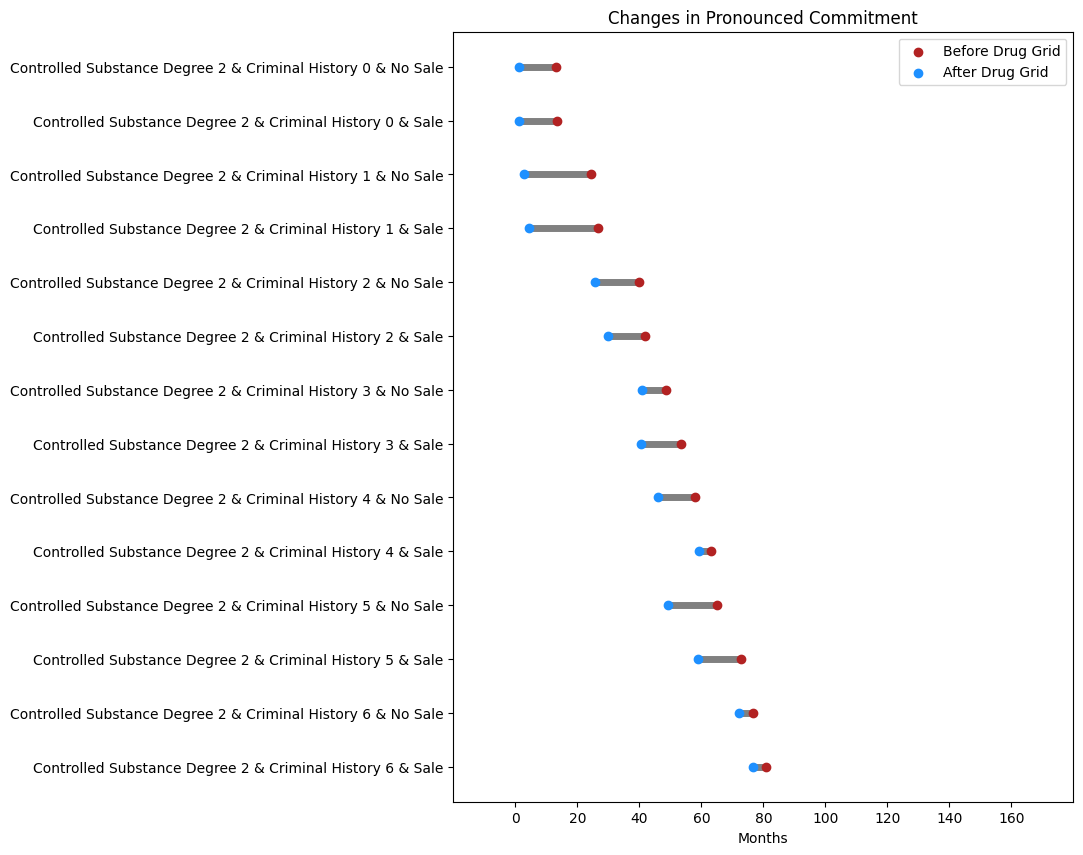

In [24]:
# Figure 3b_zoomed: Zooming in on previous figures, broken into Sale/No Sale drug offenses
df_PRE = (df_drugs[df_drugs['post'] == 0]
                                    .groupby(['offense_x_history_x_sale'])['pronounced_commitment']
                                    .agg(['mean','median','std','count'])
                                    .reset_index()
                                    .set_index('offense_x_history_x_sale')
                                )

df_POST = (df_drugs[df_drugs['post'] == 1]
                                    .groupby(['offense_x_history_x_sale'])['pronounced_commitment']
                                    .agg(['mean','std','count'])
                                    .reset_index()
                                    .set_index('offense_x_history_x_sale')
                                )

diff_df = df_POST.join(df_PRE, lsuffix='_POST', rsuffix='_PRE').assign(mean_diff = lambda x: x['mean_POST'] - x['mean_PRE'])
diff_df.index = (diff_df.index.str.replace('consub','Controlled Substance Degree ') 
                    .str.replace('_history',' & Criminal History ') 
                    .str.replace('_sale0',' & No Sale') 
                    .str.replace('_sale1',' & Sale'))
diff_df = diff_df[['mean_POST','mean_PRE','mean_diff','count_POST','count_PRE']]
diff_df = diff_df.iloc[14:28].copy() # Just 2nd Degree

# Percents of offense x histories within just 1st, 2nd, 3rd degree offenses
diff_df['total_POST'] = diff_df['count_POST'].sum()
diff_df['total_PRE'] = diff_df['count_PRE'].sum()
diff_df['percent_POST'] = diff_df['count_POST'] / diff_df['total_POST'] * 100
diff_df['percent_PRE'] = diff_df['count_PRE'] / diff_df['total_PRE'] * 100


# FIGURE: Pre- and Post- changes in presumptive commitment
fig, ax = plt.subplots(figsize=(8,10))

for idx, off_hist in enumerate(reversed(diff_df.index)):
    y = off_hist
    a = diff_df.loc[off_hist, 'mean_PRE']
    b = diff_df.loc[off_hist, 'mean_POST']
    
    percent_pre = diff_df.loc[off_hist, 'percent_PRE']
    percent_post = diff_df.loc[off_hist, 'percent_POST']
    
    ax.scatter(a, y, color='firebrick', label='Before Drug Grid' if idx == 0 else None, zorder=2)
    ax.scatter(b, y, color='dodgerblue', label='After Drug Grid' if idx == 0 else None, zorder=2)
    ax.plot([a, b], [y, y], color='gray', zorder=1, linewidth=5)
    
    # ax.text(a+5 if idx != len(diff_df.index) - 1 else a+3, y,
    #         f'{percent_pre:.1f}%' if idx != len(diff_df.index) - 1 else f'{percent_pre:.1f}%\nof total sentences before',
    #         color='firebrick', ha='left', va='center', fontsize=9)
    # ax.text(b-5 if idx != len(diff_df.index) - 1 else b-3, y,
    #         f'{percent_post:.1f}%' if idx != len(diff_df.index) - 1 else f'{percent_pre:.1f}%\nof total sentences after',
    #         color='dodgerblue', ha='right', va='center', fontsize=9)

ax.set_xlabel('Months')
ax.set_xlim(-20,180)
ax.set_xticks(np.arange(0,180,20))
ax.legend()
ax.set_title('Changes in Pronounced Commitment')

In [25]:
# PREPARING THE REGRESSION DATAFRAME
# 2nd Degree, History 0/1 versus 2/3
df_drugs = df_drugs[df_drugs['offense_x_history'].isin(['consub2_history0','consub2_history1','consub2_history2','consub2_history3'])]
df_drugs['treated'] = np.where(df_drugs['offense_x_history'].isin(['consub2_history0','consub2_history1']), 1, 0)

# 3rd Degree, History 1/2 versus 3/4
# df_drugs = df_drugs[df_drugs['offense_x_history'].isin(['consub3_history1','consub3_history2','consub3_history3','consub3_history4'])]
# df_drugs['treated'] = np.where(df_drugs['offense_x_history'].isin(['consub3_history1','consub3_history2']), 1, 0)

df_drugs['treated_x_post'] = df_drugs['treated'] * df_drugs['post']

sex_dummies = pd.get_dummies(df_drugs['sex'], dtype=int).drop(columns=['female'])
race_dummies = pd.get_dummies(df_drugs['race'], dtype=int).drop(columns=['white'])
district_dummies = pd.get_dummies(df_drugs['district'], prefix='district', dtype=int).drop(columns=['district_1.0'])
year_dummies = pd.get_dummies(df_drugs['sentyear'], prefix='year', dtype=int).drop(columns=['year_2011.0'])

df_drugs = pd.concat([df_drugs,
                      sex_dummies,
                      race_dummies,
                      district_dummies,
                      year_dummies,
                      ], axis=1)

In [9]:
# TABLE 1: SUMMARY STATISTICS
# Regular Summary Statistics
df_drugs[['time','confine','presumptive_commitment','pronounced_commitment','agesent']].agg(['mean', 'median', 'std', 'min', 'max']).round(3).T #.to_csv('..\\output\\tables\\intent_to_treat\\summary_stats_quantitative.csv')
# Demographic & Disposition Summary Statistics
df_drugs.groupby('sentyear')[['male','black','hispanic','am ind','asian','other','presumptive_disposition','pronounced_disposition']].mean().agg(['mean', 'median', 'std', 'min', 'max']).round(3).T #.to_csv('..\\output\\tables\\intent_to_treat\\summary_stats_demographic.csv')

,mean,median,std,min,max
male,0.762,0.757,0.016,0.744,0.792
black,0.242,0.238,0.065,0.133,0.373
hispanic,0.055,0.058,0.016,0.032,0.084
am ind,0.078,0.071,0.028,0.038,0.129
asian,0.022,0.023,0.009,0.008,0.033
other,0.001,0.000,0.002,0.000,0.007
presumptive_disposition,0.516,0.535,0.103,0.357,0.652
pronounced_disposition,0.346,0.350,0.106,0.208,0.502


In [42]:
# DIFFERENCE IN DIFFERENCES MODEL
outcome_variable = 'pronounced_commitment'

factors = ['treated', 'post', 'treated_x_post'] 
factors += ['agesent'] + sex_dummies.columns.tolist() + race_dummies.columns.tolist() # demographic controls
factors += district_dummies.columns.tolist() # district controls
factors += year_dummies.columns.tolist() # year controls

model_df = df_drugs[[outcome_variable] + factors].dropna()

model = sm.OLS(model_df[outcome_variable], sm.add_constant(model_df[factors])) 
results = model.fit(cov_type='HC3')
print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     pronounced_commitment   R-squared:                       0.361
Model:                               OLS   Adj. R-squared:                  0.354
Method:                    Least Squares   F-statistic:                     75.12
Date:                   Fri, 02 Aug 2024   Prob (F-statistic):               0.00
Time:                           12:22:23   Log-Likelihood:                -13697.
No. Observations:                   3019   AIC:                         2.746e+04
Df Residuals:                       2988   BIC:                         2.764e+04
Df Model:                             30                                         
Covariance Type:                     HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const         

In [ ]:
# DIFFERENCE IN DIFFERENCES MODEL FILTERED TO INDIVIDUAL GROUPS
outcome_variable = 'pronounced_commitment'

factors = ['treated', 'post', 'treated_x_post'] 
factors += ['agesent'] + sex_dummies.columns.tolist() + race_dummies.columns.tolist() # demographic controls
factors += district_dummies.columns.tolist() # district controls
factors += year_dummies.columns.tolist() # year controls

model_df = df_drugs[[outcome_variable] + factors].dropna()

model = sm.OLS(model_df[outcome_variable], sm.add_constant(model_df[factors])) 
results = model.fit(cov_type='HC3')
print(results.summary())

In [33]:
# TABLE 2: RESULTS COEFFICIENTS & STANDARD ERRORS
factor_labels = ['const'] + factors
coefficients = results.params[factor_labels]
std_errors = results.bse[factor_labels]

# zippering them the lists together to alternate rows between coef and std error how i like em
table_labels = [val for pair in zip(factor_labels, [f'{factor}_std_error' for factor in factor_labels]) for val in pair]
table_values = [val for pair in zip(coefficients, std_errors) for val in pair]

table = pd.DataFrame({'variable':table_labels, 'values':table_values})

with pd.option_context('display.max_rows', 100):
    display(table)
    
    
# HOW I GOT THIS INTO THE TABLE HOW I LIKE IT IS:
# 0) Run this block
# 1) Copy paste below into the appropriate tab in appropriate excel sheet in output/tables/intent_to_treat/results_...._commitment.csv
# 2) The excel VLOOKUP should make the second tab look 99% of the way there and then you can just beautify that table in another tab

,variable,values
0,const,36.829579
1,const_std_error,inf
2,treated,-27.054842
3,treated_std_error,inf
4,post,-3.815186
5,post_std_error,inf
6,treated_x_post,-4.022603
7,treated_x_post_std_error,inf
8,agesent,0.007454
9,agesent_std_error,inf
